In [293]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

from utils import featurewise_norm


## Principal Components Analysis

In [6]:
#ok let's load our usual data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [7]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype


dtype((numpy.record, [(u'category', 'S7'), (u'image_id', 'S40'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

In [9]:
from decomposition import get_eigenvalues

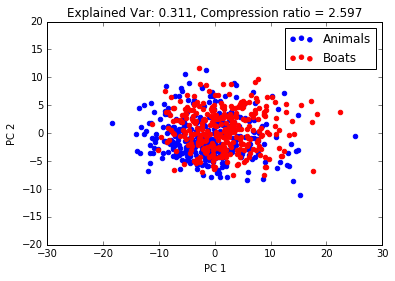

In [10]:
vl = 'V6'
cat1 = 'Animals'
cat2 = 'Boats'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

Neural_Data_subset, _ig, _ig = featurewise_norm(Neural_Data_subset)

cov = np.dot(Neural_Data_subset.T, Neural_Data_subset)

eigenvals, eigenvecs = get_eigenvalues(cov)

eigrat = eigenvals[0] / eigenvals[1]

expl_var = eigenvals[:2].sum() / eigenvals.sum()

Xproj = np.dot(Neural_Data_subset, eigenvecs)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title("Explained Var: %.3f, Compression ratio = %.3f" % (expl_var, eigrat))


#### PCA as a visualization method

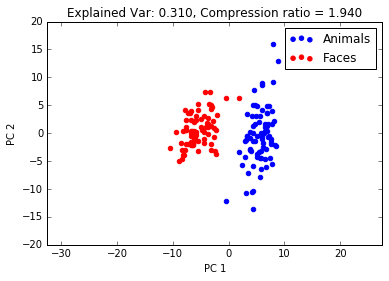

In [16]:
vl = 'V0'
cat1 = 'Animals'
cat2 = 'Faces'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

Neural_Data_subset, _ig, _ig = featurewise_norm(Neural_Data_subset)

cov = np.dot(Neural_Data_subset.T, Neural_Data_subset)

eigenvals, eigenvecs = get_eigenvalues(cov)

eigrat = eigenvals[0] / eigenvals[1]

expl_var = eigenvals[:2].sum() / eigenvals.sum()

Xproj = np.dot(Neural_Data_subset, eigenvecs)

#projection of the data onto the two most important dimensions
x = Xproj[:, 0]  #projection onto the principal axis
y = Xproj[:, 1]  #projection onto the second principal axis

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title("Explained Var: %.3f, Compression ratio = %.3f" % (expl_var, eigrat))


### In scikit form

In [738]:
class PCA(object):
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, train_data):
        data, self.fmean, self.fvar = featurewise_norm(train_data)
        cov = np.dot(data.T, data)
        eigenvals, eigenvecs = get_eigenvalues(cov)
        self.eigenvals = eigenvals
        self.eigenvecs = eigenvecs
        
    def transform(self, test_data):
        data, _ig, _ig = featurewise_norm(test_data, fmean=self.fmean, fvar=self.fvar)
        Xproj = np.dot(data, self.eigenvecs)
        return Xproj[:, :self.n_components]

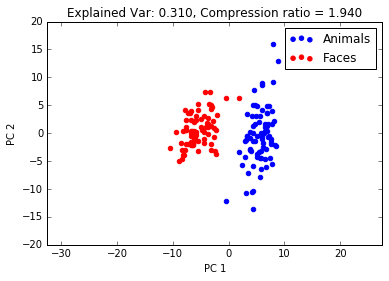

In [18]:
vl = 'V0'
cat1 = 'Animals'
cat2 = 'Faces'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

cls = PCA(n_components=2)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)
eigrat = cls.eigenvals[0] / cls.eigenvals[1]
expl_var = cls.eigenvals[:2].sum() / cls.eigenvals.sum()

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title("Explained Var: %.3f, Compression ratio = %.3f" % (expl_var, eigrat))


In [19]:
from sklearn.decomposition import PCA as sklearn_PCA

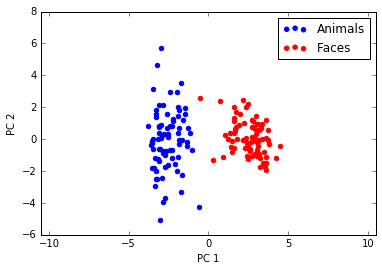

In [20]:
cls = sklearn_PCA(n_components=2)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()


#### Whitening

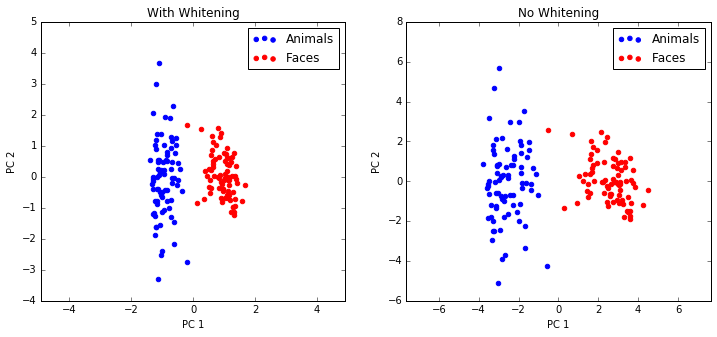

In [36]:
vl = 'V0'
cat1 = 'Animals'
cat2 = 'Faces'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

cls = sklearn_PCA(n_components=2, whiten=True)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title('With Whitening')


cls_nowhite = sklearn_PCA(n_components=2, whiten=False)
cls_nowhite.fit(Neural_Data_subset)

Xproj_nowhite = cls_nowhite.transform(Neural_Data_subset)

x_nowhite = Xproj_nowhite[:, 0]
y_nowhite = Xproj_nowhite[:, 1]

xb_nowhite = x_nowhite[category_subset == cat1]
yb_nowhite = y_nowhite[category_subset == cat1]
xc_nowhite = x_nowhite[category_subset == cat2]
yc_nowhite = y_nowhite[category_subset == cat2]
plt.subplot(1,2,2)
plt.scatter(xb_nowhite, yb_nowhite, color='b', label=cat1)
plt.scatter(xc_nowhite, yc_nowhite, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title('No Whitening')


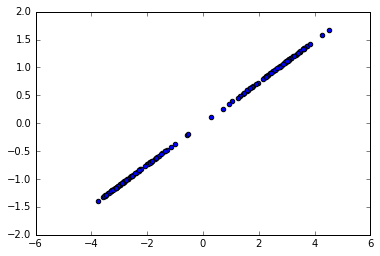

In [43]:
#the whitened output is proportionate to the unwhitened
plt.scatter(Xproj_nowhite[:, 0], Xproj[:, 0])

In [53]:
#the proportion is 1 / sqrt(eigenvalue) in each eigendimension
#... so here's the first dimension
(Xproj_nowhite[:, 0] / Xproj[:, 0])[0]


2.7045684

In [54]:
#... so here's the second dimension
(Xproj_nowhite[:, 1] / Xproj[:, 1])[0]

1.5507805

In [45]:
#... and here's the eigenvalues 
cls_nowhite.explained_variance_
#Q: why named this?? recall result about relationship between 
#eigenvalues and explained variance

array([7.3146906, 2.40492  ], dtype=float32)

In [52]:
#... and their square roots
np.sqrt(cls_nowhite.explained_variance_)

array([2.7045684, 1.5507805], dtype=float32)

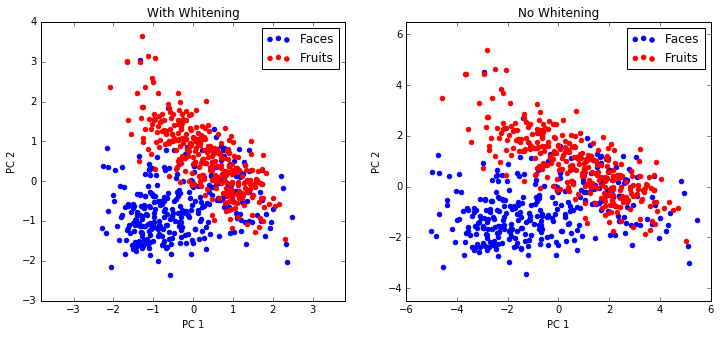

In [23]:
#we can look at it more complex situation
vl = 'V3'
cat1 = 'Faces'
cat2 = 'Fruits'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

cls = sklearn_PCA(n_components=2, whiten=True)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title('With Whitening')


cls = sklearn_PCA(n_components=2, whiten=False)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.subplot(1,2,2)
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title('No Whitening')



#### Incremental PCA

In [24]:
from sklearn.decomposition import IncrementalPCA

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/incremental_pca.py:271: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


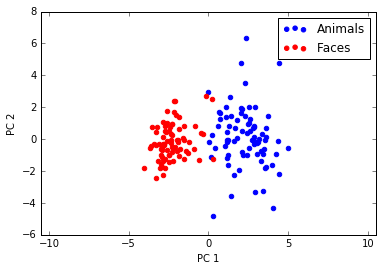

In [35]:
cls = IncrementalPCA(n_components=2, batch_size=2)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()


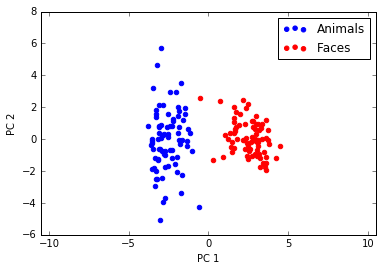

In [33]:
cls = IncrementalPCA(n_components=2, batch_size=100)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()


### Probabilistic Interpretation of PCA

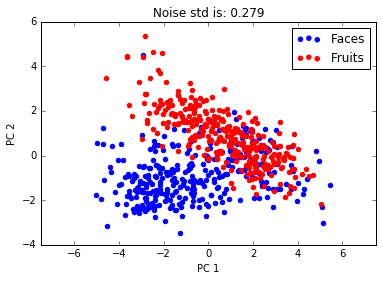

In [26]:
cls = sklearn_PCA(n_components=2)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
std = (cls.noise_variance_)**(.5)
plt.title('Noise std is: %.3f' % std)

## Factor Analysis

In [27]:
from sklearn.decomposition import FactorAnalysis

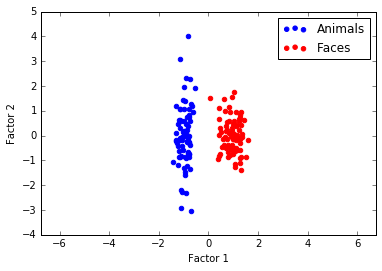

In [28]:
vl = 'V0'
cat1 = 'Animals'
cat2 = 'Faces'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

cls_fa = FactorAnalysis(n_components=2)
cls_fa.fit(Neural_Data_subset)

Xproj = cls_fa.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend()


In [29]:
#See, now the noise variance is estimated separately for each dimension
cls_fa.noise_variance_.shape

(168,)

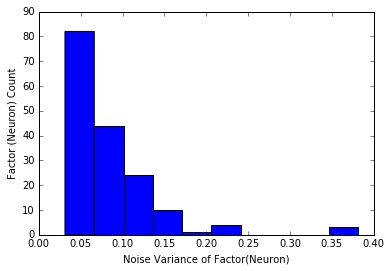

In [30]:
#Let's look at the noise estimate for each factor (here, factors=IT neurons)
plt.hist(cls_fa.noise_variance_)
plt.xlabel('Noise Variance of Factor(Neuron)')
plt.ylabel('Factor (Neuron) Count')

### Comparing PCA and Factor Analysis

best n_components by PCA CV = 10
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 10
best n_components by PCA CV = 40
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 38


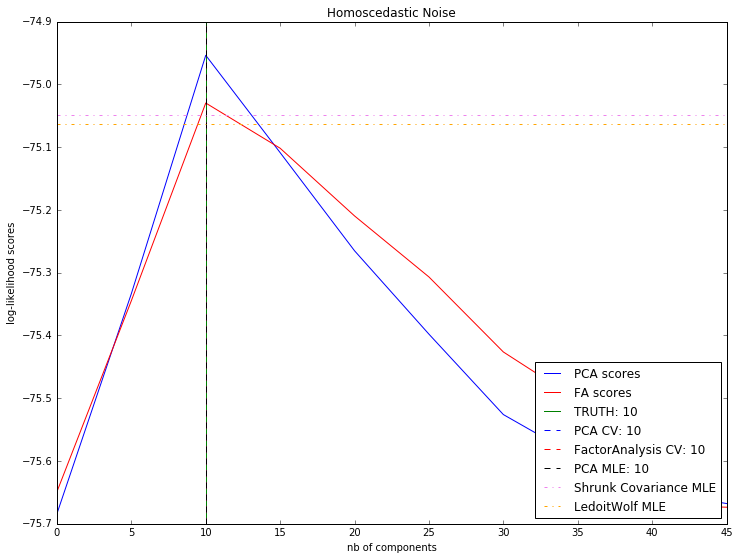

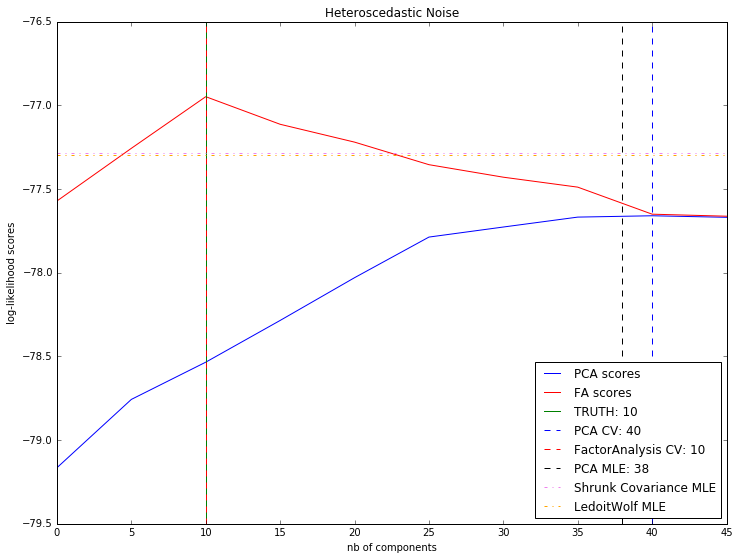

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# #############################################################################
# Create the data

n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure(figsize=(12, 9))
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('log-likelihood scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

## CCA

#### Generate and visualize example data

In [718]:
def look_at_data(toy_data, title=None, perm=None):
    #let's look at the data
    use_colors = []
    num_points = toy_data.shape[0]
    sta_color = np.asarray((1,0,0))
    end_color = np.asarray((0,1,0))
    for idx in xrange(num_points):
        use_colors.append((sta_color*idx + end_color*(num_points-idx))*1.0/num_points)
    if perm is not None:
        use_colors = np.asarray(use_colors)[perm]
    plt.scatter(toy_data[:, 0], toy_data[:, 1], c=use_colors)
    plt.axis('equal')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    if title is not None:
        ax.set_title(title)

In [719]:
#generate X
rng = np.random.RandomState(seed=0)
num_points = 200
data_mean = np.array([0, 0])
data_cov = 10*np.array([[0.5, 0.3], [0.3, 0.5]])
toy_data_x = rng.multivariate_normal(mean=data_mean,
                                   cov=data_cov, size=200)

x_data = np.arange(-2, 2, 4.0/num_points)
y_data = np.arange(2, -2, -4.0/num_points)
toy_data_x[:, 0] += x_data
toy_data_x[:, 1] += y_data

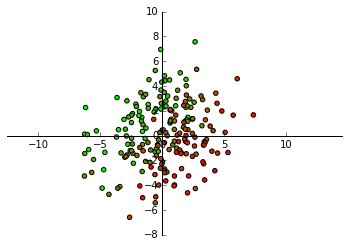

In [720]:
look_at_data(toy_data_x)

In [721]:
#generate Y
rng = np.random.RandomState(seed=1)
num_points = 200
data_mean = np.array([0, 0])
data_cov = 10*np.array([[0.5, -0.3], [-0.3, 0.5]])
toy_data_y = rng.multivariate_normal(mean=data_mean,
                                   cov=data_cov, size=200)

x_data = np.arange(-2, 2, 4.0/num_points)
y_data = np.arange(-2, 2, 4.0/num_points)
toy_data_y[:, 0] += x_data
toy_data_y[:, 1] += y_data

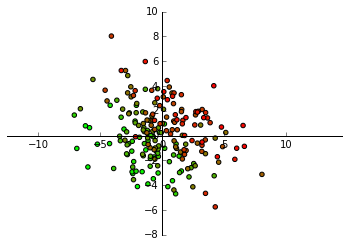

In [722]:
look_at_data(toy_data_y)

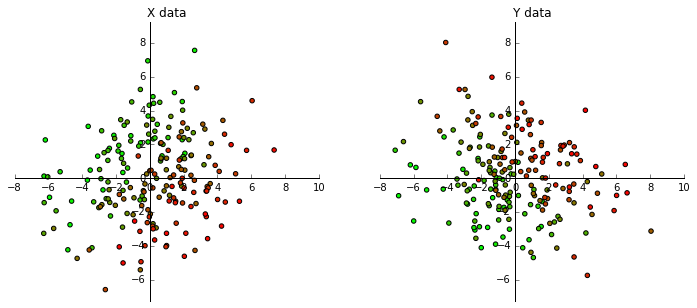

In [723]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data')
plt.subplot(122)
look_at_data(toy_data_y, title='Y data')

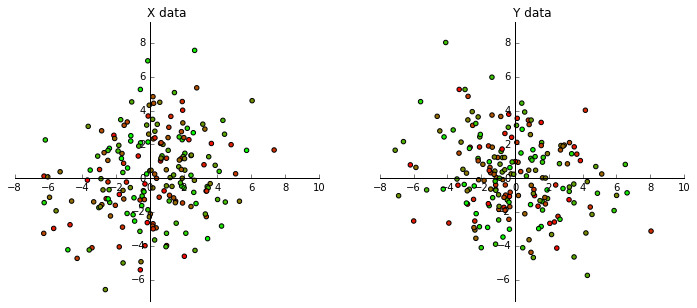

In [724]:
rng = np.random.RandomState(seed=2)
perm = rng.permutation(num_points)
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data', perm=perm)
plt.subplot(122)
look_at_data(toy_data_y, title='Y data', perm=perm)

## Do the CCA

In [725]:
from sklearn.cross_decomposition import CCA

In [726]:
cca = CCA(n_components=1)

In [727]:
cca.fit(toy_data_x, toy_data_y)

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [728]:
cca.x_weights_

array([[ 0.78793394],
       [-0.61575978]])

In [729]:
cca.y_weights_

array([[0.71298775],
       [0.70117649]])

In [730]:
trans_res = cca.transform(toy_data_x, toy_data_y)

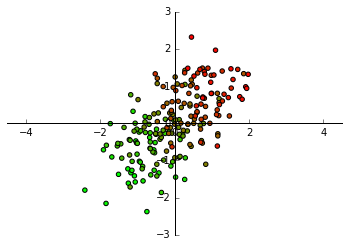

In [731]:
new_data = np.concatenate((trans_res[0], trans_res[1]), axis=1)
#print(new_data.shape)
look_at_data(new_data)

## Visualize the projection dimension on each data

In [739]:
def add_one_line(pt_x, pt_y, color=(0,0,1)):
    norm = 7
    plt.plot((pt_x*norm, -pt_x*norm), (pt_y*norm, -pt_y*norm), linewidth=3, color=color)

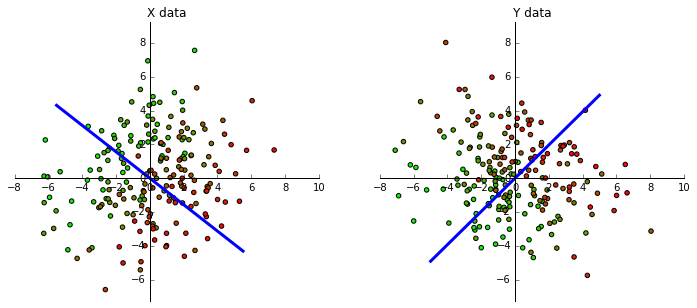

In [740]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data')
plt.hold(True)
add_one_line(*cca.x_weights_)
plt.subplot(122)
look_at_data(toy_data_y, title='Y data')
add_one_line(*cca.y_weights_)

In [743]:
pca = sklearn_PCA(n_components=1)

In [744]:
pca.fit(toy_data_x)
x_line = pca.components_

In [745]:
pca.fit(toy_data_y)
y_line = pca.components_

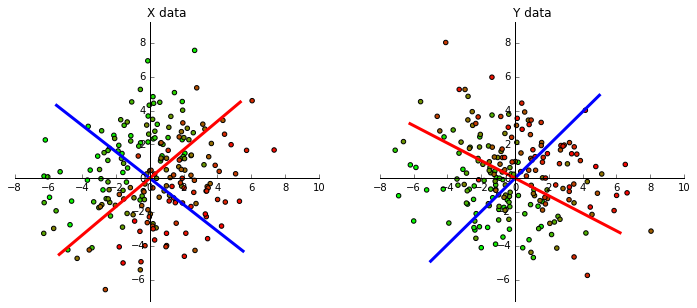

In [746]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data')
plt.hold(True)
add_one_line(*cca.x_weights_)
add_one_line(x_line[0][0], x_line[0][1], color=(1,0,0))
plt.subplot(122)
look_at_data(toy_data_y, title='Y data')
add_one_line(*cca.y_weights_)
add_one_line(y_line[0][0], y_line[0][1], color=(1,0,0))

## CCA on neural data

In [747]:
def plot_neural_cca(vl = 'V6', cat1 = 'Animals', cat2 = 'Faces', which_cmp=1):
    subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
    subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
    subset_inds = np.concatenate([subset_inds1, subset_inds2])
    IT_subset = IT_Neural_Data[subset_inds]
    V4_subset = V4_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]

    cls = CCA(n_components=which_cmp)
    cls.fit(V4_subset, IT_subset)

    Xproj = cls.transform(V4_subset, IT_subset)

    x = Xproj[0][:,which_cmp-1]
    y = Xproj[1][:,which_cmp-1]
    
    corr_val = np.corrcoef(x,y)[0,1]

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b', label=cat1)
    plt.scatter(xc, yc, color='r', label=cat2)
    plt.axis('equal')
    plt.xlabel('V4 Data')
    plt.ylabel('IT Data')
    plt.legend()
    plt.title('Correlation value %f' % corr_val)

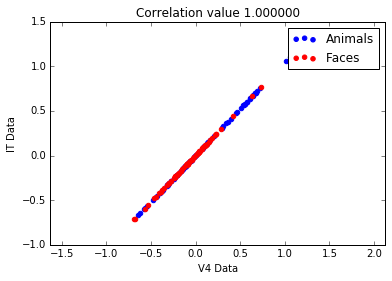

In [748]:
plot_neural_cca(vl='V0', which_cmp=1)

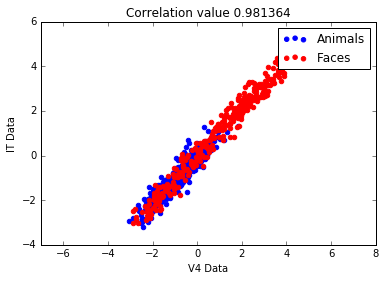

In [749]:
plot_neural_cca(vl='V3', which_cmp=1)

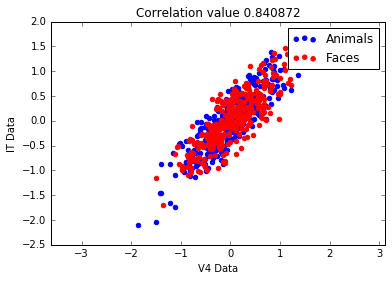

In [750]:
plot_neural_cca(vl='V3', which_cmp=10)

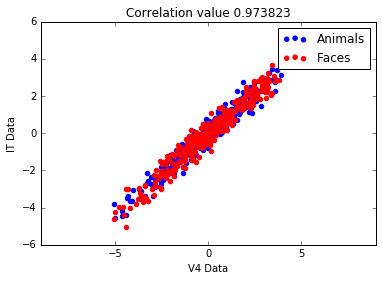

In [751]:
plot_neural_cca(vl='V6')

In [752]:
def plot_corr_neural_cca(vl = 'V6', num_cmp=1, label=''):
    subset_inds = (var_level == vl).nonzero()[0]
    IT_subset = IT_Neural_Data[subset_inds]
    V4_subset = V4_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]

    cls = CCA(n_components=num_cmp)
    cls.fit(V4_subset, IT_subset)

    Xproj = cls.transform(V4_subset, IT_subset)

    all_corr = []
    for which_idx in xrange(num_cmp):
        x = Xproj[0][:,which_idx]
        y = Xproj[1][:,which_idx]

        corr_val = np.corrcoef(x,y)[0,1]
        all_corr.append(corr_val)
    plt.plot(all_corr, label=label)

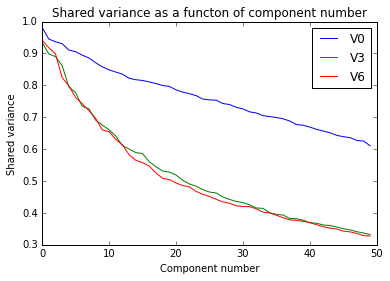

In [755]:
num_cmp=50
plot_corr_neural_cca(vl='V0', num_cmp=num_cmp, label='V0')
plt.hold(True)
plot_corr_neural_cca(vl='V3', num_cmp=num_cmp, label='V3')
plot_corr_neural_cca(vl='V6', num_cmp=num_cmp, label='V6')
plt.legend(loc='best')
plt.xlabel('Component number')
plt.ylabel('Shared variance')
plt.title('Shared variance as a functon of component number')

# ICA

In [759]:

#this is the derivative of the log(cosh(x)) function
g = lambda x: np.tanh(x)
#this is the second derivative of the log(cosh(x)) function
gprime = lambda x: (1 - g(x)**2)


def norm(v):
    return v / np.linalg.norm(v)


def whiten(data):
    """a generic whitening function
    """
    #center the data
    data, _fmean, _fvar = featurewise_norm(data)
    #compute the data covariance matrix
    cov = np.dot(data.T, data)
    #get the eigenvalues and vectors of the data covariance matrix
    vals, vecs  = get_eigenvalues(cov)
    #compute data * vecs * (vals)^{-1/2}
    #... d = eigenvals^{-1/2}, as diagonal of a matrix
    d = np.sqrt((1. / vals)) * np.identity(data.shape[1])
    #this is the whitening matrix
    whitening = np.dot(vecs, d)
    #now actually whiten the data
    data = np.dot(data, whitening) * np.sqrt(data.shape[0])
    return data, whitening


def fastica_onedim(data, comps_so_far, tol=1e-3, seed=0, max_iter=200):
    """Computes ICA component that is orthogonal to whatever is in comps_so_far
    """
    #we're going to choose a random initial vector so
    #we need to create a rng 
    rng = np.random.RandomState(seed=seed)
    n, m = data.shape
    #now pick a random vector with m components (total # of features in the data)
    w = rng.rand(m)
    #normalize it
    w = norm(w)
    
    #now, in a loop:
    i = 0
    while True:
        #construct the non-gaussianity negentropy measure
        #a = first term
        a = (data * g(np.dot(data, w))[:, np.newaxis]).mean(0)
        #b = second term
        b = gprime(np.dot(data, w)).mean() * w
        #take difference to form negentropy update
        new_w = a - b
        #deflate out components we want to avoid
        new_w = new_w - np.array([np.dot(new_w, c) * c for c in comps_so_far]).sum(0)
        #normalize
        new_w = norm(new_w)
        #get difference of new_w to previous w
        diff = np.linalg.norm(new_w - w)
        w = new_w
        #if new_w is sufficiently similar to old w ....
        #... or max iterations has been reached, 
        #then break the loop
        if diff < tol or i > max_iter:
            break
        i += 1
    return w
  
    
def fastica(data, n_comps, tol=1e-5, max_iter=300):
    """main fastica implementation
       inputs: data matrix of shape (num_samples, num_features)
       n_comps: number of independent coefficients to find
       tol: tolerance for declaring the algorithm has converged
       max_iter: maximum number of iterations allowed
       
       returns:
           unmixing matrix
           whitening matrix
    """
    data, whitening = whiten(data)
    unmixing = []
    for i in range(n_comps):
        new_comp = fastica_onedim(data, unmixing, tol=tol, seed=i, max_iter=max_iter)
        unmixing.append(new_comp)
    return np.array(unmixing), whitening


class FastICA(object):
    """sklearn-consistent FastICA class
    """
    def __init__(self, n_comps, tol=1e-4, max_iter=200):
        self.n_comps = n_comps
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, data):
        unmixing, whitening = fastica(data, 
                                      n_comps=self.n_comps, 
                                      tol=self.tol,
                                      max_iter=self.max_iter)
        self.unmixing = unmixing
        self.whitening = whitening
        self.components_ = np.dot(unmixing, whitening.T)
        
    def transform(self, data):
        data = featurewise_norm(data)[0]
        sources = np.dot(data, self.components_.T)
        return sources
        
        

In [760]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Signal 1 : sinusoidal signal
s1 = np.sin(2 * time)  
# Signal 2 : square signal
s2 = np.sign(np.sin(3 * time))  
# Signal 3: saw tooth signal
s3 = signal.sawtooth(2 * np.pi * time)  
# Signal 4: butterworth impulse
imp = signal.unit_impulse(50, 'mid')
b, a = signal.butter(4, 0.2)
response = signal.lfilter(b, a, imp)
response = response[10:]
org_x_val = np.arange(0, 1, 1.0 / 40)
new_x_val = np.arange(0, 1, 1.0 / 200)
response = np.interp(new_x_val, org_x_val, response)
response = np.tile(response, [10])
response = response*5
response = response - np.mean(response)
s4 = response

#the four signals
S = np.c_[s1, s2, s3, s4]

# Add noise
S += 0.2 * np.random.normal(size=S.shape)  

# Standardize data
S /= S.std(axis=0)  

# Mix it up!
A = np.array([[1, 1, 1, 1], 
              [0.5, 2, 1.0, 1.5], 
              [1.5, 1.0, 2.0, 0.5], 
              [2.0, 1.0, 0.5, 1.5]])  
#A is the "mixing matrix"

# Actually do the mixture to generate "observations"
X = np.dot(S, A.T)  

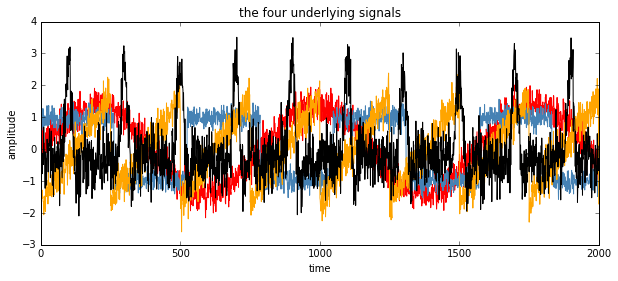

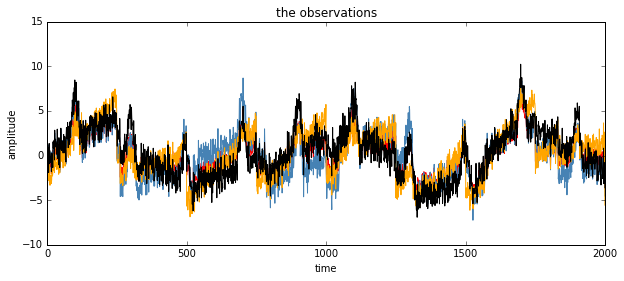

In [761]:
colors = ['red', 'steelblue', 'orange', 'black']
fig_size = (10, 4)
fig = plt.figure(figsize=fig_size)
for sig, color in zip(S.T, colors):
    plt.plot(sig, color=color)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('the four underlying signals')

fig = plt.figure(figsize=fig_size)
for sig, color in zip(X.T, colors):
    plt.plot(sig, color=color)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('the observations')

In [765]:
#ok let's apply our ICA algorithm
ica = FastICA(n_comps=4)
ica.fit(X)
S_ = ica.transform(X)

pca = sklearn_PCA(n_components=4)
H = pca.fit_transform(X)

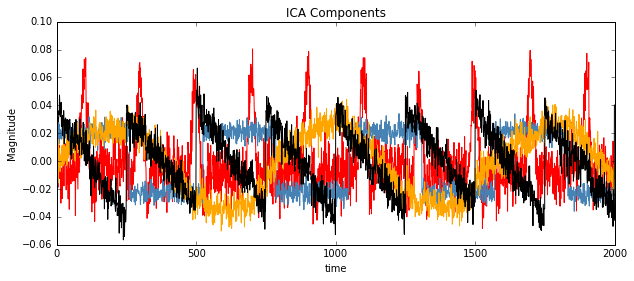

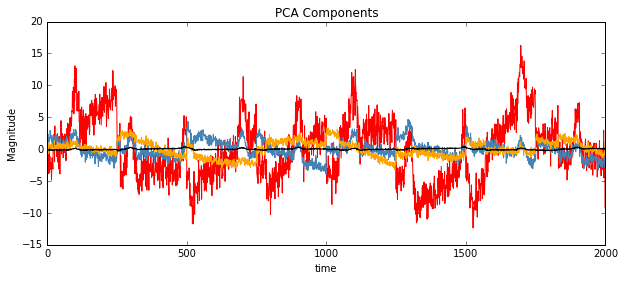

In [766]:
colors = ['red', 'steelblue', 'orange', 'black']
fig_size = (10, 4)
fig = plt.figure(figsize=fig_size)
for sig, color in zip(S_.T, colors):
    plt.plot(sig, color=color)
plt.xlabel('time')
plt.ylabel('Magnitude')
plt.title('ICA Components')
    
fig = plt.figure(figsize=fig_size)
for sig, color in zip(H.T, colors):
    plt.plot(sig, color=color)
plt.xlabel('time')
plt.ylabel('Magnitude')
plt.title('PCA Components')

In [712]:
cls = FastICA(n_comps=8, tol=1e-5, max_iter=300)
cls.fit(IT_Neural_Data)

In [713]:
Xproj = cls.transform(IT_Neural_Data)

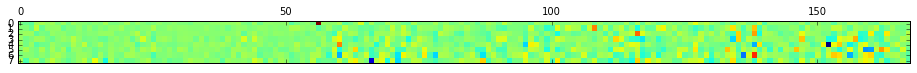

In [714]:
plt.figure(figsize=(12, 5))
plt.matshow(cls.components_)

In [715]:
Xproj[:, 0]

array([-0.00757711, -0.0020558 , -0.00488142, ...,  0.00678714,
        0.00449153, -0.00137825])

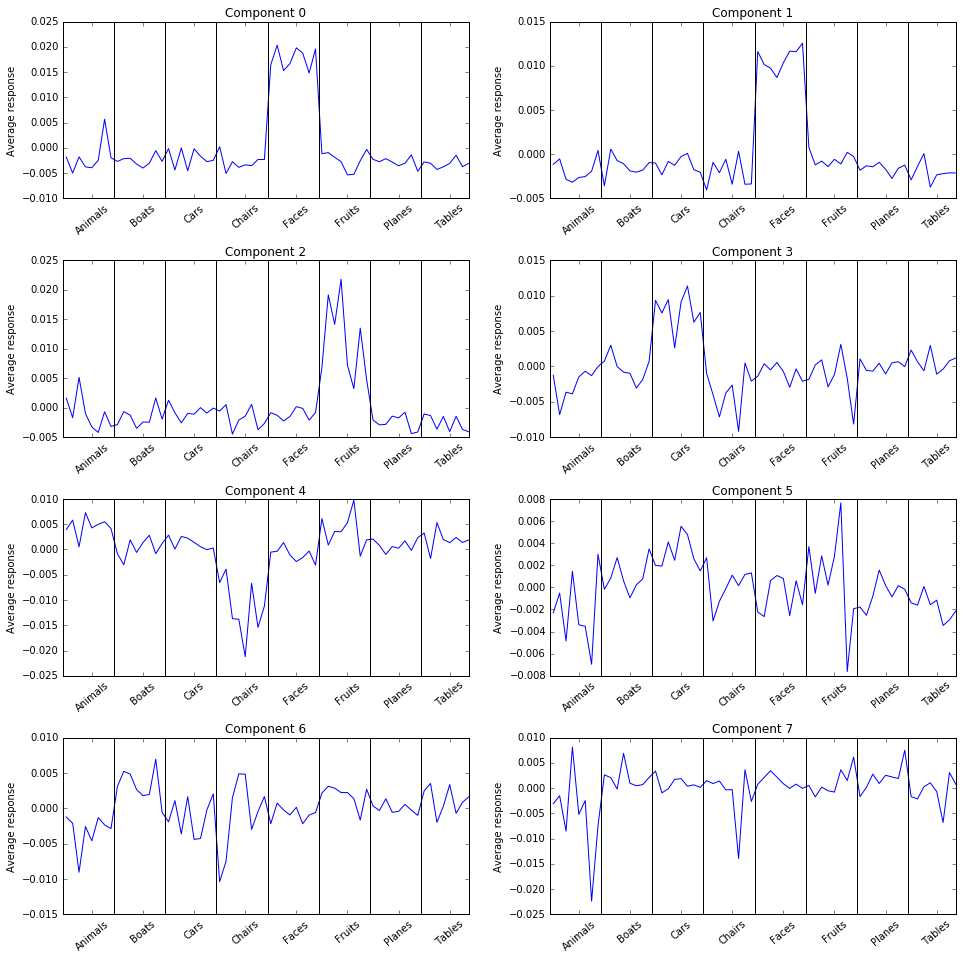

In [716]:

plt.figure(figsize=(16, 16))
for i in range(8):
    plt.subplot(4, 2, i+1)
    sorted_nd = [Xproj[meta_array['object_name'] == o, i].mean() for c in unique_categories for o in objects_by_category[c] ]
    plt.plot(sorted_nd)
    plt.ylabel('Average response')
    plt.title('Component %d' % i)
    plt.xticks(np.arange(8)*8+4, unique_categories, rotation=40)
    [plt.axvline(xv, color='k') for xv in np.arange(8)*8 - 0.5];

plt.subplots_adjust(hspace=0.35)